### Result
As we can see in $\lambda = 10^{-3}$ we get the best perdormance of cnn.

But there is no significant influece is observed in weights

In [20]:
#initializing
#this block should be run once , for the other process from the third block of the jupyter, it should be run

list_of_Trainacc_l1=[0,0,0,0,0,0,0,0,0,0]
list_of_Validacc_l1=[0,0,0,0,0,0,0,0,0,0]
lambdaa2=[]

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

In [112]:
lambdaa=[100,10,1,0,10**(-1),10**(-2),10**(-3),10**(-4),10**(-5),10**(-6)]
lambdaa2.append(lambdaa[len(lambdaa2)])
lambdi=lambdaa2[-1]
print(lambdi)

1e-06


### Read data

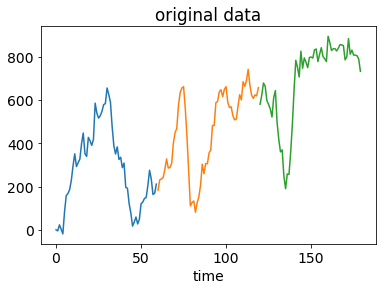

data:  10000


In [113]:
A=500
str0 = f'ts_L60_Z12_A{A}_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

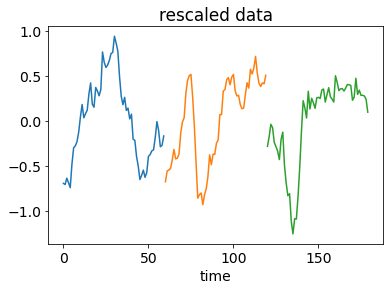

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [114]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [115]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

## from keras import regularizers, initializers

reg = tf.keras.regularizers.l1(lambdi) ## raised to 0.2
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                        seed=None)
NCONV = 1
NF = 5

# challenge: at most 600 tunable parameters
model = Sequential()
# 
if NCONV==1:
    # -----2-----
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
# 
if NCONV==2:
    # -----1-----
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg, ######## TRY WITHOUT !
                     activation='relu', input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Flatten())
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.3))
model.add(Dense(n_class, activation='softmax')) # softmax !

print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

----- Model 1 -----
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 50, 5)             60        
                                                                 
 average_pooling1d_11 (Avera  (None, 10, 5)            0         
 gePooling1D)                                                    
                                                                 
 conv1d_23 (Conv1D)          (None, 4, 5)              180       
                                                                 
 flatten_11 (Flatten)        (None, 20)                0         
                                                                 
 dense_22 (Dense)            (None, 12)                252       
                                                                 
 dropout_11 (Dropout)        (None, 12)                0         
                                 

In [116]:
model.layers

In [117]:
def Show_weights(model,l=0,label="model",a='0'):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.savefig('fig_layer '+str(l)+'_lambda '+str(a)+'.png')
    plt.show()
    
    
# Show_weights(model,0)
# Show_weights(model,2)

In [118]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 250
EPOCHS = 100

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 

----- Model  1 -----
FITTING....
Epoch 1/100
32/32 - 1s - loss: 1.0966 - accuracy: 0.3483 - val_loss: 1.0918 - val_accuracy: 0.3790 - 776ms/epoch - 24ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0829 - accuracy: 0.4038 - val_loss: 1.0674 - val_accuracy: 0.4275 - 160ms/epoch - 5ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0419 - accuracy: 0.4831 - val_loss: 1.0116 - val_accuracy: 0.5295 - 191ms/epoch - 6ms/step
Epoch 4/100
32/32 - 0s - loss: 0.9701 - accuracy: 0.5702 - val_loss: 0.9182 - val_accuracy: 0.6530 - 163ms/epoch - 5ms/step
Epoch 5/100
32/32 - 0s - loss: 0.8853 - accuracy: 0.6317 - val_loss: 0.8124 - val_accuracy: 0.7145 - 161ms/epoch - 5ms/step
Epoch 6/100
32/32 - 0s - loss: 0.7777 - accuracy: 0.6996 - val_loss: 0.7027 - val_accuracy: 0.7670 - 155ms/epoch - 5ms/step
Epoch 7/100
32/32 - 0s - loss: 0.6812 - accuracy: 0.7487 - val_loss: 0.5943 - val_accuracy: 0.8110 - 154ms/epoch - 5ms/step
Epoch 8/100
32/32 - 0s - loss: 0.5862 - accuracy: 0.7832 - val_loss: 0.4956 - val_accuracy: 0.8440

Epoch 67/100
32/32 - 0s - loss: 0.0926 - accuracy: 0.9721 - val_loss: 0.0848 - val_accuracy: 0.9700 - 165ms/epoch - 5ms/step
Epoch 68/100
32/32 - 0s - loss: 0.0909 - accuracy: 0.9718 - val_loss: 0.0820 - val_accuracy: 0.9730 - 165ms/epoch - 5ms/step
Epoch 69/100
32/32 - 0s - loss: 0.0858 - accuracy: 0.9741 - val_loss: 0.0810 - val_accuracy: 0.9735 - 152ms/epoch - 5ms/step
Epoch 70/100
32/32 - 0s - loss: 0.0833 - accuracy: 0.9771 - val_loss: 0.0810 - val_accuracy: 0.9735 - 189ms/epoch - 6ms/step
Epoch 71/100
32/32 - 0s - loss: 0.0881 - accuracy: 0.9731 - val_loss: 0.0804 - val_accuracy: 0.9735 - 217ms/epoch - 7ms/step
Epoch 72/100
32/32 - 0s - loss: 0.0865 - accuracy: 0.9750 - val_loss: 0.0798 - val_accuracy: 0.9735 - 176ms/epoch - 6ms/step
Epoch 73/100
32/32 - 0s - loss: 0.0838 - accuracy: 0.9750 - val_loss: 0.0789 - val_accuracy: 0.9745 - 160ms/epoch - 5ms/step
Epoch 74/100
32/32 - 0s - loss: 0.0857 - accuracy: 0.9739 - val_loss: 0.0786 - val_accuracy: 0.9730 - 156ms/epoch - 5ms/step


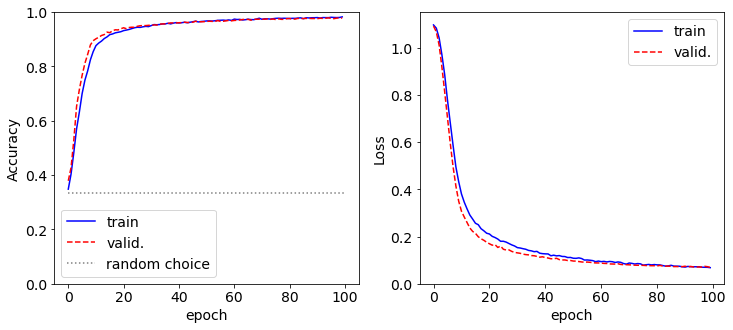

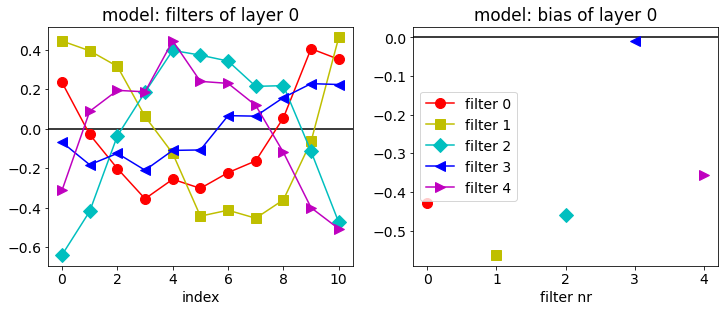

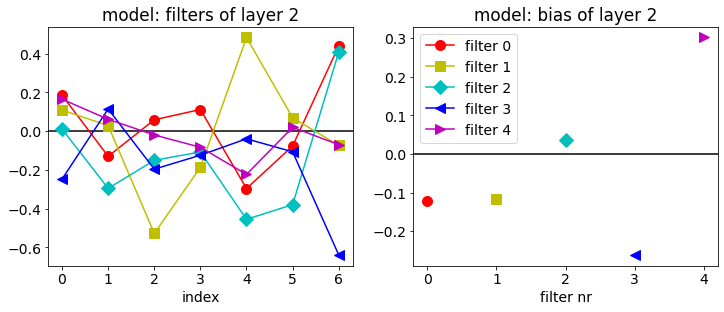

[0.3317500054836273, 0.32862499356269836, 0.3323749899864197, 0.9827499985694885, 0.8533750176429749, 0.9758750200271606, 0.984000027179718, 0.9835000038146973, 0.9817500114440918, 0.9821249842643738]
[0.3330000042915344, 0.3330000042915344, 0.3330000042915344, 0.9785000085830688, 0.8550000190734863, 0.9764999747276306, 0.9819999933242798, 0.9800000190734863, 0.9760000109672546, 0.9775000214576721]


In [119]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0,a=len(lambdaa2)-1)
Show_weights(model,2,a=len(lambdaa2)-1)
list_of_Trainacc_l1[len(lambdaa2)-1]=fit.history['accuracy'][-1]
list_of_Validacc_l1[len(lambdaa2)-1]=fit.history['val_accuracy'][-1]
print(list_of_Trainacc_l1)
print(list_of_Validacc_l1)

In [120]:
TYPE=1
def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"
print("Trainacc",list_of_Trainacc_l1)
print("Validacc",list_of_Validacc_l1)
np.savetxt(filename("Trainacc_lambda_l1",TYPE),list_of_Trainacc_l1)
np.savetxt(filename("Validacc_lambda_l1",TYPE),list_of_Validacc_l1)

Trainacc [0.3317500054836273, 0.32862499356269836, 0.3323749899864197, 0.9827499985694885, 0.8533750176429749, 0.9758750200271606, 0.984000027179718, 0.9835000038146973, 0.9817500114440918, 0.9821249842643738]
Validacc [0.3330000042915344, 0.3330000042915344, 0.3330000042915344, 0.9785000085830688, 0.8550000190734863, 0.9764999747276306, 0.9819999933242798, 0.9800000190734863, 0.9760000109672546, 0.9775000214576721]


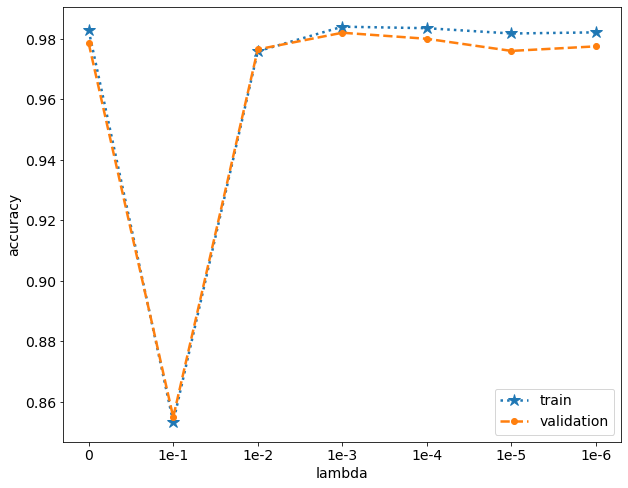

In [121]:
import numpy as np
import matplotlib.pyplot as plt
TYPE=1
def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"
x = np.loadtxt(filename("Trainacc_lambda_l1",TYPE), delimiter=' ')
y = np.loadtxt(filename("Validacc_lambda_l1",TYPE), delimiter=' ')
lambdaa=[100,10,1,0,10**(-1),10**(-2),10**(-3),10**(-4),10**(-5),10**(-6)]

#lambdaa=[1e-2,1e-3,1e-4,1e-5,1e-6]
m=[0,1,2,3,4,5,6]
lambdaa1=['0','1e-1','1e-2','1e-3','1e-4','1e-5','1e-6']
x=x[3:10]
y=y[3:10]
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(m, x, label = 'train', linestyle = 'dotted', marker = '*', markersize = 12,linewidth ='2.5')
ax.plot(m, y, label = 'validation',linestyle = 'dashed', marker = '.',markersize = 12, linewidth ='2.5')
ax.set_xlabel('lambda')
ax.set_ylabel('accuracy')
#plt.xticks(m,size=10)
ax.set_xticks(m)

ax.set_xticklabels(lambdaa1)

plt.legend(loc = 'best')
plt.savefig('plot_lambda_l1.png')